**Bellman Equations for Policy Search**

In this exercise, we are going to implement the Bellman equations for policy search in the next MDP, known as The Cliff:

![alt text](cliff_problem.png "Title")

Let us start with the imports. We use numpy and matplotlib, and the magic command `%matplotlib inline` to show the results in the notebook. We also use Gym, tabulate, and tqdm to keep track of the computation time.

In [6]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
try:
  import gym.spaces as gs
except:
  !pip install gym
  import gym.spaces as gs
from tabulate import tabulate
from tqdm import tqdm

The next thing we do is to seed the random number generator. This is done to ensure that the results are reproducible. At this point, this is not strictly necessary, but it is good practice to do so (and when working with Deep Reinforcement Learning, it is absolutely necessary).

In [7]:
seed = 1234
rng = np.random.default_rng(1234)

First, we copy the Cliff environment from a previous example, to use it in this problem.

In [8]:
class grid(object):  # Create the GridWorld class

    def __init__(self, dims=(3, 3), seed=1234):
        self.dims = dims  # Gridworld dims (rows x cols)
        self.observation_space = gs.Box(low=np.array([0, 0]), high=np.array([self.dims[0] - 1, self.dims[1] - 1]), dtype=int, seed=seed)  # The observations are the coordinates of each grid cell
        self.action_space = gs.Discrete(4, seed=seed)  #  There are 4 possible actions: 0=up, 1=down, 2=left, 3=right
        self.init_state = (self.dims[0] - 1, 0)  # Initial state, always the same for simplicity: lower left corner
        self.target_state = (self.dims[0] - 1, self.dims[1] - 1)  # Target state: always the same for simplicity: lower right corner
        self.cliff_location = [(self.dims[0] - 1, i) for i in range(1, self.dims[1] - 1)]  # Lower row (except for target and initial state)
        self.state = None  # This is to store data later on

    def reset(self, randomize=False):  # Call this method to reset the environment
        if randomize:  # To use a random initial state
            self.state = self.observation_space.sample()
        else:
            self.state = self.init_state  # Use a fixed initial state
        return self.state

    def step(self, action):  # This method implements the environment transition

        action = np.squeeze(action).astype(int).item()  # Prepare action (make it an integer just in case)
        if action < 0 or action > 3:  # Check the action bounds
            raise RuntimeError('Action out of bounds')
        # Perform action to get next state (i.e., move the agent in the grid world)
        if action == 0:
            next_state = self.state + np.array([1, 0])  # Move down
        elif action == 1:
            next_state = self.state + np.array([-1, 0])  # Move up
        elif action == 2:
            next_state = self.state + np.array([0, -1])  # Move left
        elif action == 3:
            next_state = self.state + np.array([0, 1])  # Move right
        # Set the action bounds correctly, as we may end up out of the grid
        next_state = np.clip(next_state, np.zeros(2), np.array(self.dims) - 1).astype(int)
        # Check reward and termination condition
        reward, done = self.reward_done(next_state)
        self.state = next_state  # Change the state in the class
        return next_state, reward, done, {}  # Return next state, reward and whether episode has ended

    def from_index(self, index):  # Ancillary method: convert an index state to state coordinates
        return np.unravel_index(index, self.dims)

    def to_index(self, state):  # Ancillary method: convert state coordinates to index
        return np.ravel_multi_index(state, self.dims)

    def reward_done(self, state):
      if tuple(state) in self.cliff_location:  # We fall off the cliff
        reward = -100  # Highly penalizing reward: you die
        done = True  # Episode is terminated
      elif np.sum(np.abs(state - np.array(self.target_state))) < 1e-4:  # Final target found
        reward = 0  # Final reward is 0
        done = True  # Episode is terminated
      else:  # We haven't neither reached the target nor fallen off the cliff
        reward = -1  # Standard reward (takes another step)
        done = False  # Episode not terminated yet
      return reward, done

    def action_to_str(self, action):
      def ac2str(action):
        if action == 0:
          return 'down'
        if action == 1:
          return 'up'
        if action == 2:
          return 'left'
        if action == 3:
          return 'right'
      if isinstance(action, list):
        return [ac2str(a) for a in action]
      else:
        return ac2str(action)

In the next code, we define our environment, and use exhaustive search to find the optimal policy. The steps given are:
* First, we define the environment, and the discount factor $\gamma$. You have to be very careful with the environment dimensions: since we will use exhaustive search, the time required to try all policies grows *very* fast!
* Second, we obtain $\mathcal{P}$ and $\mathcal{R}$, the probability transition matrix and the reward vector. We use the `step` method of the environment to obtain the next state and reward for each state-action pair. We do that in order to evaluate every policy using the linear Bellman equations.
* Third, we do an exhaustive search over all the policies in order to find the optimal one. Be very careful with the number of policies: it grows exponentially with the number of states and actions! Thus, this approach has very clear limits: the so-called *curse of dimensionality*. In this case, we have $3 \cdot 3=9$ states, and $4$ actions, so the number of policies is $4^9=262144$. This is a very large number, and the exhaustive search will take a while. For this reason, we use the `tqdm` package to show a progress bar.

In [9]:
env = grid(dims=(3, 3), seed=seed)  # Careful here, as complexity increases with dims fast!!

# Proceed with an exhaustive search over all possible policies
gamma = 0.9  # Discount factor
nstates = int(np.prod(env.dims))  # Total number of states, i.e., grid cells
nactions = 4  # Number of actions available
# Obtain P and R
P = np.zeros((nstates * nactions, nstates))  # To store Probability Transition matrix
R = np.zeros((nstates * nactions, 1))  # To store Reward vector
for state_action in range(nstates * nactions):  # For each state-action pair
    state = state_action // 4  # Integer division: get the state
    action = state_action % 4  # Module of division: get the action
    env.state = np.array(env.from_index(state))  # Set the state in the class (to use the step method in next line)
    next_state, reward, _, _ = env.step(action)  # Get the next state and reward calling the step() method
    P[state_action, env.to_index(next_state)] = 1  # Deterministic transition: only one entry per row!
    R[state_action, 0] = reward  # The reward obtained

# The number of policies is nactions ** nstates: careful with nstates here!!
vmax = np.amin(R) * 100 * np.ones((nstates, 1))  # Very low initial value (to be replaced during search)
Pi_opt = None  # Optimal policy (so far, None)
if nactions ** nstates > 1e5:  # This warning just reminds of the computational cost of this method
    print('Warning: computing Bellman over ', nactions ** nstates, ' possible policies may take a while...')
for i in tqdm(range(nactions ** nstates)):
    policy = np.base_repr(i, base=nactions)  # Obtain the policy by using a base-4 conversion of the index i (exhaustive tree search)
    while len(policy) < nstates:
        policy = '0' + policy  # To have the adequate dimension in the policy string
    Pi = np.zeros((nstates, nstates * nactions))  # Empty policy to test
    for j in range(nstates):  # Fill the policy
        action = int(policy[j])  # Action for state j
        Pi[j, j * nactions + action] = 1  # Deterministic policy: only one entry per row
    v = np.linalg.inv(np.eye(nstates) - gamma * Pi @ P) @ Pi @ R  # Optimal V function, using Bellman equation
    if np.all(v >= vmax):  # If this value is higher than the value stored for all states (i.e., optimal value)
        vmax = v  # Best value (so far)
        Pi_opt = Pi  # Best policy (so far)
# After the tree has finished searching, we have that Pi_opt is the optimal policy: get optimal V and Q functions
v_opt = np.linalg.inv(np.eye(nstates) - gamma * Pi_opt @ P) @ Pi_opt @ R  # Optimal V using Bellman
q_opt = np.linalg.inv(np.eye(nstates * nactions) - gamma * P @ Pi_opt) @ R  # Optimal Q using Bellman
q_opt = q_opt.reshape([nstates, 4])  # To make it more readable, states x actions

pi_opt = np.zeros((nstates,))  # Make it readable: optimal action for each state
for i in range(nstates):
    pi_opt[i] = np.where(Pi_opt[i] == 1)[0][0] - env.action_space.n * i  # Action index

100%|██████████| 262144/262144 [00:11<00:00, 23650.24it/s]


Let us now show the optimal policy, which is the one you would expect: avoiding the clif by walking on its edge.

In [10]:
# Now, plot the results obtained in the policy search
st = np.zeros(env.dims)
for i in range(nstates):
  state = env.from_index(i)
  st[state[0], state[1]] = i
print('States index')
print(tabulate(st, tablefmt="fancy_grid"))
print('Optimal V-function and policy')
vals = [i for i in zip(range(nstates), list(v_opt.flatten()), env.action_to_str(list(pi_opt)), list(q_opt[:, 0]), list(q_opt[:, 1]), list(q_opt[:, 2]), list(q_opt[:, 3]))]
headers=['State index', 'V optimal', 'Policy']
for i in range(4):
  headers.append('Q ' + env.action_to_str(i))
print(tabulate(vals, tablefmt="fancy_grid", headers=headers))

States index
╒═══╤═══╤═══╕
│ 0 │ 1 │ 2 │
├───┼───┼───┤
│ 3 │ 4 │ 5 │
├───┼───┼───┤
│ 6 │ 7 │ 8 │
╘═══╧═══╧═══╛
Optimal V-function and policy
╒═══════════════╤═════════════╤══════════╤══════════╤════════╤══════════╤═══════════╕
│   State index │   V optimal │ Policy   │   Q down │   Q up │   Q left │   Q right │
╞═══════════════╪═════════════╪══════════╪══════════╪════════╪══════════╪═══════════╡
│             0 │       -2.71 │ right    │   -2.71  │ -3.439 │   -3.439 │     -2.71 │
├───────────────┼─────────────┼──────────┼──────────┼────────┼──────────┼───────────┤
│             1 │       -1.9  │ right    │   -1.9   │ -2.71  │   -3.439 │     -1.9  │
├───────────────┼─────────────┼──────────┼──────────┼────────┼──────────┼───────────┤
│             2 │       -1    │ down     │   -1     │ -1.9   │   -2.71  │     -1.9  │
├───────────────┼─────────────┼──────────┼──────────┼────────┼──────────┼───────────┤
│             3 │       -1.9  │ right    │   -3.439 │ -3.439 │   -2.71  │     -1.9  │

Another possible way of finding a good policy is by randomly sampling policies and checking their value. Note that this method does not guarantee finding the optimal policy, and, as shown in the next example, the policies obtained may be arbitrarily bad. However, it is a good way of showing the limits of random search, even in a small problem as this. Hence, in order to find the optimal policies, we need to use more advanced tecniques, that we will study in the next lectures.

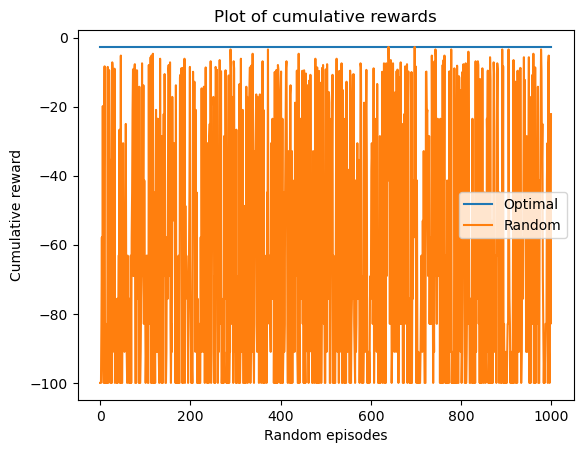

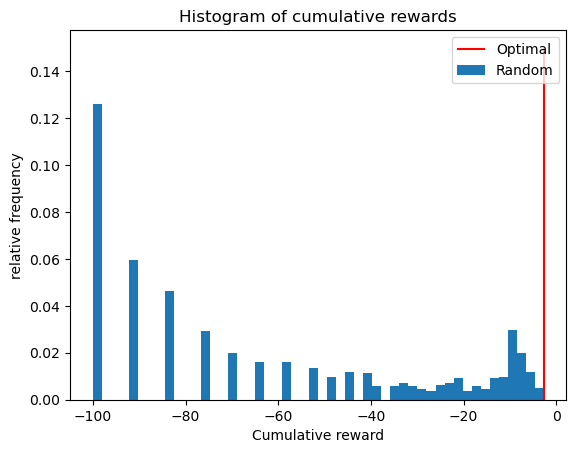

The proportion of random trajectories whose reward is equal to the optimal is  0.002


In [11]:
# Trajectory reward for optimal and random policies
reward_optimal = 0
state = env.reset()
done = False
t = 0
while not done:
  action = pi_opt[env.to_index(state)]  # Select the optimal action
  state, reward, done, _ = env.step(action)
  reward_optimal += reward * gamma ** t
  t += 1

n_random = 1000  # Number of random trajectories to check
reward_random = [0 for _ in range(n_random)]
for e in range(n_random):  # For each episode
  state = env.reset()
  done = False
  t = 0
  while not done:
    action = env.action_space.sample()  # Randomly sample one of the possible actions
    state, reward, done, _ = env.step(action)
    reward_random[e] += reward * gamma ** t
    t += 1

# Plot results
plt.plot(reward_optimal * np.ones((n_random)), label='Optimal')
plt.plot(reward_random, label='Random')
plt.xlabel('Random episodes')
plt.ylabel('Cumulative reward')
plt.legend(loc='best')
plt.title('Plot of cumulative rewards')
plt.show()

plt.vlines(reward_optimal, ymin=0, ymax=0.15, color='r', label='Optimal')
plt.hist(reward_random, bins=50, density=True, label='Random')
plt.xlabel('Cumulative reward')
plt.ylabel('relative frequency')
plt.title('Histogram of cumulative rewards')
plt.legend(loc='best')

plt.show()

print('The proportion of random trajectories whose reward is equal to the optimal is ', np.sum(np.abs(np.array(reward_random) - reward_optimal)<1e-4) / n_random)